# Sine Wave Generator

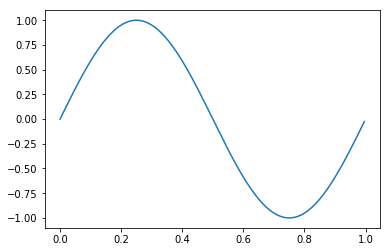

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def sine(x):
    return np.sin(2 * math.pi * x)

x = np.linspace(0., 1., num=256, endpoint=False)

plt.plot(x, sine(x))

In [2]:
import magma as m
m.set_mantle_target("ice40")

In [3]:
import mantle
from loam.boards.icestick import IceStick

N = 8

icestick = IceStick()
icestick.Clock.on()
for i in range(N):
    icestick.J3[i].output().on()

import lattice ice40
import lattice mantle40


To implement our sine wave generator, we'll use a counter to index into a ROM that is programmed to output the value of discrete points in the sine wave. 

In [4]:
main = icestick.main()

counter = mantle.Counter(32)
sawtooth = counter.O[8:8+8]

wavetable = 128 + 127 * sine(x)
wavetable = [int(x) for x in wavetable]

rom = mantle.Memory(height=256, width=16, rom=list(wavetable), readonly=True)

m.wire( rom(sawtooth)[0:8], main.J3 )
m.wire( 1, rom.RE )

m.EndCircuit()

Compile and test.

In [5]:
m.compile('build/sin', main)

In [6]:
%%bash
cd build
cat sin.pcf
yosys -q -p 'synth_ice40 -top main -blif sin.blif' sin.v
arachne-pnr -q -d 1k -o sin.txt -p sin.pcf sin.blif 
icepack sin.txt sin.bin
iceprog sin.bin

set_io J3[7] 44
set_io J3[6] 45
set_io J3[5] 47
set_io J3[4] 48
set_io J3[3] 56
set_io J3[2] 60
set_io J3[1] 61
set_io J3[0] 62
set_io CLKIN 21


init..
cdone: high
reset..
cdone: low
flash ID: 0x20 0xBA 0x16 0x10 0x00 0x00 0x23 0x64 0x34 0x65 0x03 0x00 0x71 0x00 0x26 0x27 0x12 0x16 0xD3 0xE4
file size: 32220
erase 64kB sector at 0x000000..
programming..
reading..
VERIFY OK
cdone: high
Bye.


We can wire up the GPIO pins to a logic analyzer to verify that our circuit produces the correct sine waveform.

![](images/sine.png)

We can also use Saleae's [export data](https://support.saleae.com/hc/en-us/articles/115005986806-Saving-Loading-and-Exporting-Data) feature to output a [csv file](data/sine-capture.csv). We'll load this data into Python and plot the results.

In [7]:
import csv
import magma as m
with open("data/sine-capture.csv") as sine_capture_csv:
    csv_reader = csv.reader(sine_capture_csv)
    next(csv_reader, None)  # skip the headers
    rows = [row for row in csv_reader]
timestamps = [float(row[0]) for row in rows]
values = [m.bitutils.seq2int(tuple(int(x) for x in row[1:])) for row in rows]

**TODO**: Why do we have this jitter? Logic analyzer is running at 25 MS/s, 3.3+ Volts for 1s

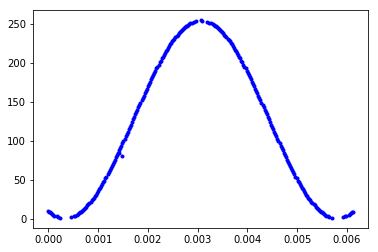

In [8]:
plt.plot(timestamps[:250], values[:250], "b.")